In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Download the stock price data from Yahoo Finance
data = yf.download('RELIANCE.NS', start='2012-01-01', end='2022-01-01')

# Extract the 'Close' price as the target variable
df = pd.DataFrame(data['Close'])

[*********************100%***********************]  1 of 1 completed


In [2]:
# Preprocess the data
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Prepare the train and test data
def prepare_data(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 30  # Number of previous days to consider as input
X_train, y_train = prepare_data(train_data.values, lookback)
X_test, y_test = prepare_data(test_data.values, lookback)


In [3]:
# Reshape the input data for MLP
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_mlp = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# MLP
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', random_state=42)
mlp.fit(X_train_mlp, y_train)
mlp_predictions = mlp.predict(X_test_mlp)

mlp_predictions = scaler.inverse_transform(mlp_predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_predictions))
mlp_mae = mean_absolute_error(y_test, mlp_predictions)
mlp_mape = np.mean(np.abs((y_test - mlp_predictions) / y_test)) * 100


C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
# CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, 1)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1))
cnn.compile(optimizer='adam', loss='mse')
cnn.fit(X_train, y_train, epochs=50, verbose=0)

cnn_predictions = cnn.predict(X_test)
cnn_predictions = scaler.inverse_transform(cnn_predictions)
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_predictions))
cnn_mae = mean_absolute_error(y_test, cnn_predictions)
cnn_mape = np.mean(np.abs((y_test - cnn_predictions) / y_test)) * 100



15/15 [==============================] - 1s 3ms/step


In [5]:
# RNN
from tensorflow.keras.layers import SimpleRNN

rnn = Sequential()
rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(lookback, 1)))
rnn.add(Dense(1))
rnn.compile(optimizer='adam', loss='mse')
rnn.fit(X_train, y_train, epochs=50, verbose=0)

rnn_predictions = rnn.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_predictions))
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mape = np.mean(np.abs((y_test - rnn_predictions) / y_test)) * 100



15/15 [==============================] - 2s 8ms/step


In [6]:
# LSTM
from tensorflow.keras.layers import LSTM

lstm = Sequential()
lstm.add(LSTM(units=50, activation='relu', input_shape=(lookback, 1)))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=50, verbose=0)

lstm_predictions = lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mape = np.mean(np.abs((y_test - lstm_predictions) / y_test)) * 100



15/15 [==============================] - 1s 11ms/step


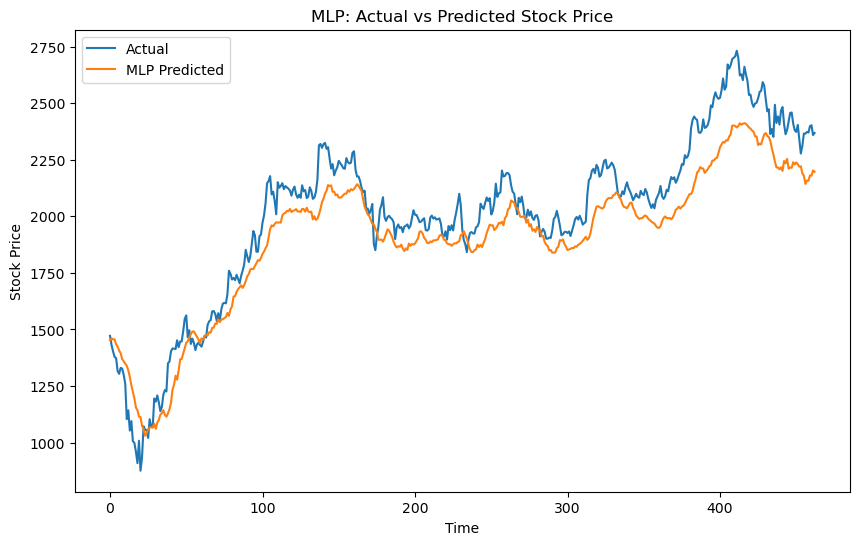

In [13]:
# Plot individual graphs for actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(mlp_predictions, label='MLP Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('MLP: Actual vs Predicted Stock Price')
plt.legend()
plt.show()




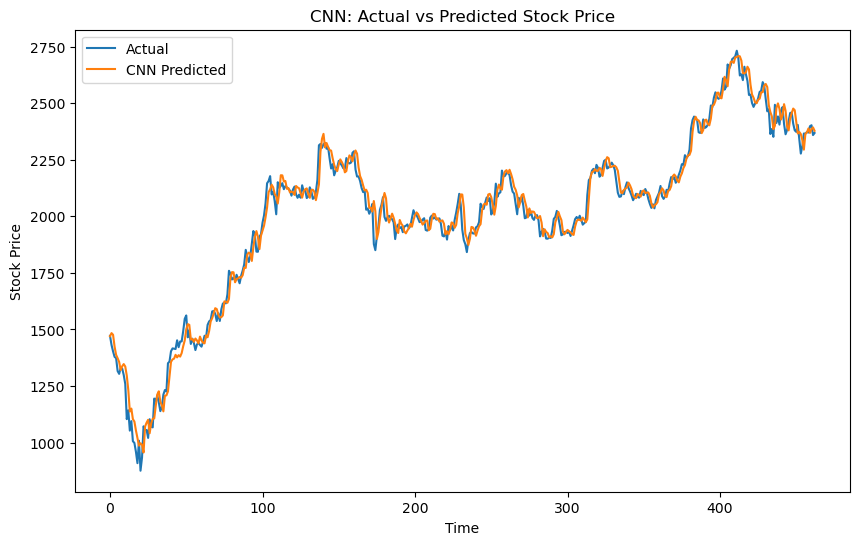

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(cnn_predictions, label='CNN Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('CNN: Actual vs Predicted Stock Price')
plt.legend()
plt.show()



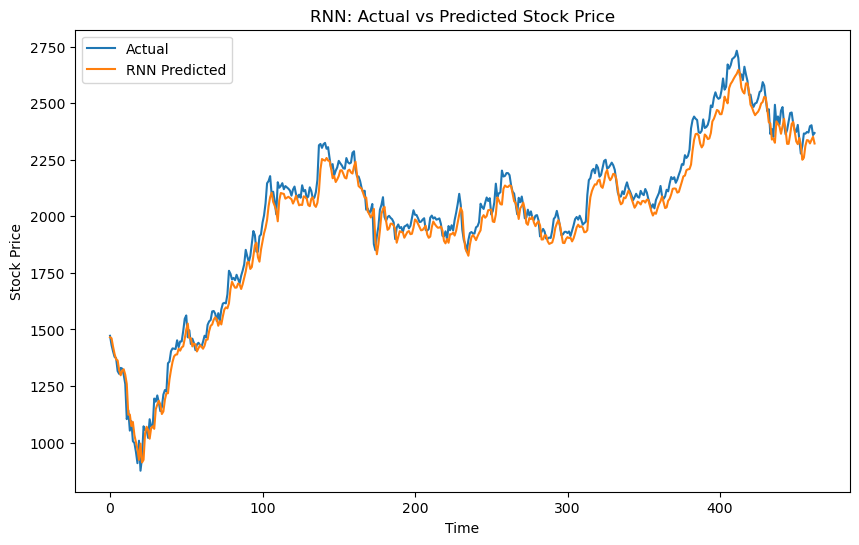

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(rnn_predictions, label='RNN Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('RNN: Actual vs Predicted Stock Price')
plt.legend()
plt.show()



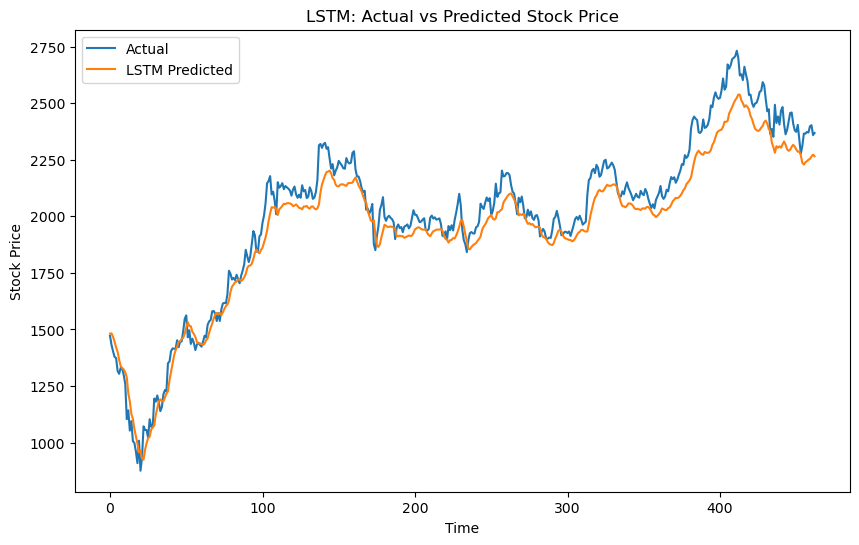

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(lstm_predictions, label='LSTM Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('LSTM: Actual vs Predicted Stock Price')
plt.legend()
plt.show()

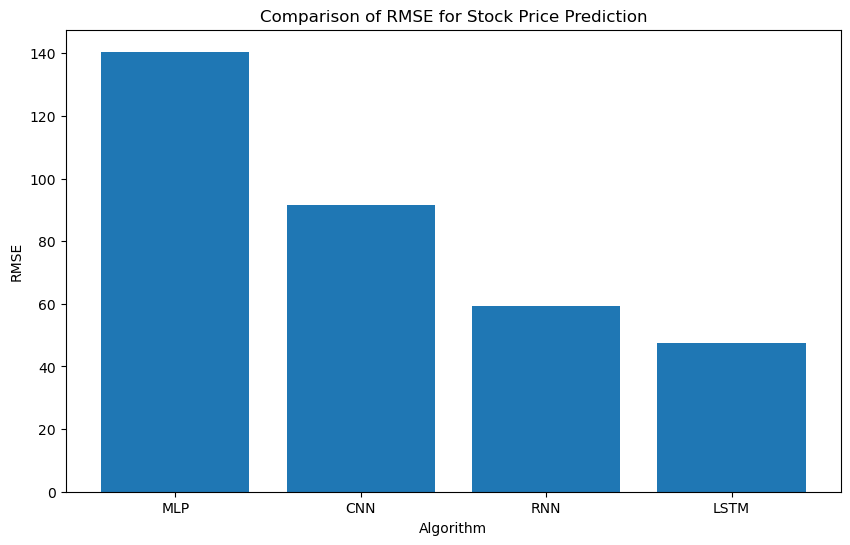

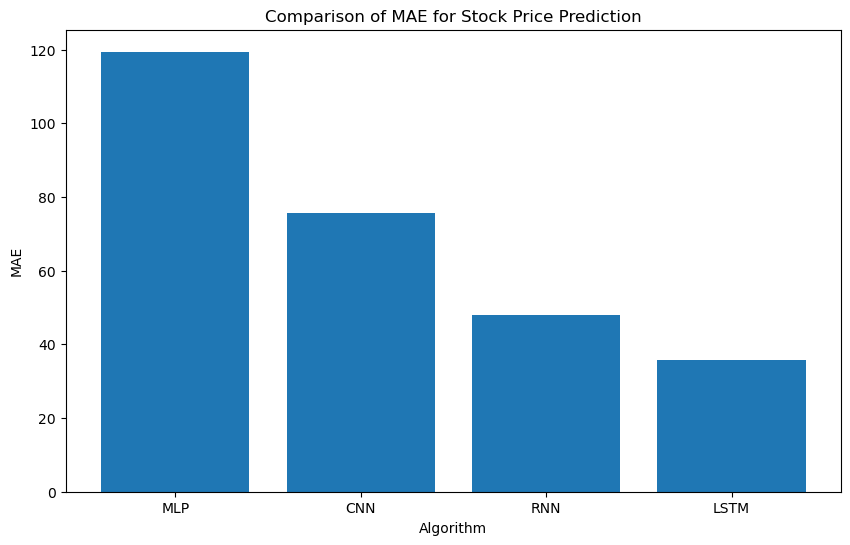

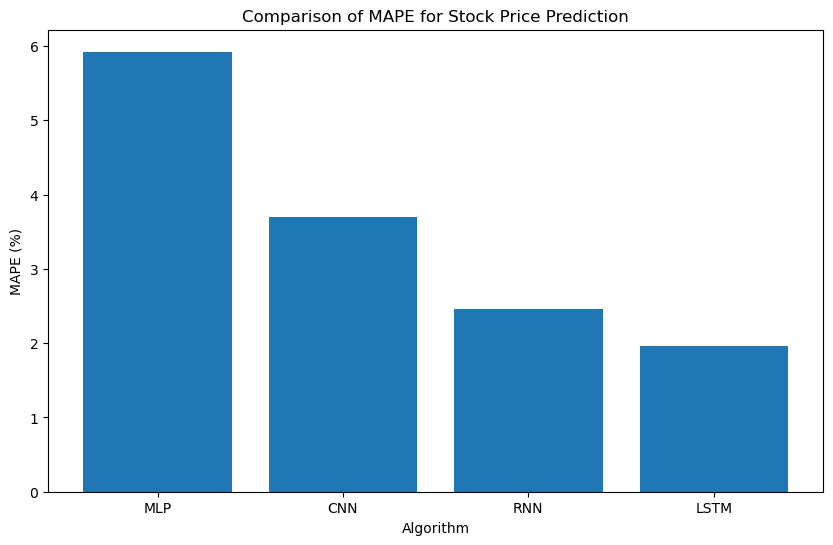

In [9]:
# Compare accuracy of each algorithm
labels = ['MLP', 'CNN', 'RNN', 'LSTM']
rmse_values = [mlp_rmse, lstm_rmse, rnn_rmse, cnn_rmse]
mae_values = [mlp_mae, lstm_mae, rnn_mae, cnn_mae]
mape_values = [mlp_mape, lstm_mape, rnn_mape, cnn_mape]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_values)
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Stock Price Prediction')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(labels, mae_values)
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.title('Comparison of MAE for Stock Price Prediction')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(labels, mape_values)
plt.xlabel('Algorithm')
plt.ylabel('MAPE (%)')
plt.title('Comparison of MAPE for Stock Price Prediction')
plt.show()
